# Mesh Alignment

This tutorial aids the alignment of multiple meshes

Utilizing vtk and some help functions, it allows to align multiple vtk mesh files, either in a rigid body manner, or in a similarity manner (rigid body + scaling)


The tutorial uses the data included in the subdirectory **data**.

## Python Packages required:

- matplotlib

- numpy

- vtk

- pandas


## Recommended Optional software

- [meshal](http://www.meshlab.net): Useful to manipulate a mesh object (esp. for mesh decimation)

- [paraview](https://www.paraview.org/): Useful to simply visualise mesh objects and roughly align them together

- [MITK](https://mitk.org/): Needed to pick (ordered) landmark on each mesh using the point picking plugin





## Landmark Picking

In this particular tutorial, the alignment is guided by some (at least) 4 landmarks picked on the surface of each mesh. Such landmarks can be picked using the [MITK](www.mitk.org) software. 

Open each mesh on MITK, and, using the landmark plugin, pick ordered points on the surface and save the set using the same naming convention as the mesh file. 


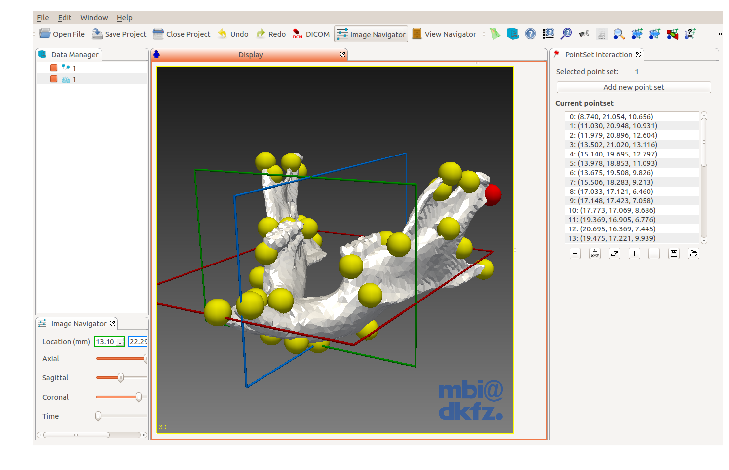

In [1]:
%matplotlib inline
import os
from matplotlib import pyplot as plt
pngfilename = os.path.join(os.getcwd(), 'Images', 'mitk-landmark-picking.png')
plt.figure(figsize=(14,8))
plt.imshow(plt.imread(pngfilename))
plt.axis('off')
plt.show()

## Read landmarks

Reads landmarks picked using [MITK](https://mitk.org/) point picking plugin

The output is a numpy array containing landmark positions

In [3]:

### read LMS file
def read_mps_file(landmarksfile):
    """Read MPS file (from [MITK](http://mitk.org/wiki/The_Medical_Imaging_Interaction_Toolkit_(MITK)))
        Converts the XML landmarks into a Numpy array
    """
    ### import XML reader
    import xml.etree.ElementTree as ET
    import numpy as np
    ### read file
    tree = ET.parse(landmarksfile)
    root = tree.getroot()
    ### list elements which tags are 'point'
    point_elements = [elem for elem in root.iter() if (elem is not root) and (elem.tag == 'point')]
    ### feed the numpy array
    lms = np.zeros([len(point_elements), 3])
    for idx, p in enumerate(point_elements):
        lms[idx, 0] = float(p.find('x').text)
        lms[idx, 1] = float(p.find('y').text)
        lms[idx, 2] = float(p.find('z').text)
    return lms


## numpy -- vtk help functions

transform function between vtk and numpy formats

In [4]:

def numpy_landmarks_to_vtk(numpy_landmarks_array):
    import vtk
    import numpy as np
    import open3d as o3d

    landmarksgroup = vtk.vtkMultiBlockDataGroupFilter()
    for landmarks in numpy_landmarks_array:
        pts = vtk.vtkPoints()
        for landmark in landmarks:
            pts.InsertNextPoint(landmark[0], landmark[1], landmark[2])
        poly = o3d.io.read_point_cloud
        poly.SetPoints(pts)
        landmarksgroup.AddInputData(poly)
    return landmarksgroup

def vtk_to_numpy_landmarks(vtk_multiblock_dataset):
    import vtk
    import numpy as np

    number_of_landmarksets = vtk_multiblock_dataset.GetNumberOfBlocks()    
    number_of_landmarks = vtk_multiblock_dataset.GetBlock(0).GetNumberOfPoints()
    landmarks = np.zeros([number_of_landmarksets, number_of_landmarks, 3])
    for id1 in range(number_of_landmarksets):
        for id2 in range(number_of_landmarks):
            l = vtk_multiblock_dataset.GetBlock(id1).GetPoint(id2)
            landmarks[id1, id2] = l            
    return landmarks


def centroid(vtk_points):
    import vtk
    import numpy as np

    cp = [0] * 3
    np = vtk_points.GetNumberOfPoints()
    for i in range(np):
        p = vtk_points.GetPoint(i)
        cp[0] += p[0]; cp[1] += p[1]; cp[2] += p[2];
    cp[0] /= np; cp[1] /= np; cp[2] /= np;
    return cp

def centroid_size(vtk_points):
    import vtk
    import numpy as np

    cp = centroid(vtk_points)
    n = vtk_points.GetNumberOfPoints()
    S = 0
    for i in range(n):
        p = vtk_points.GetPoint(i)
        S += vtk.vtkMath.Distance2BetweenPoints(p,cp)
    return np.sqrt(S)

def scale_shape(vtk_points, factor):
    import vtk
    import numpy as np

    np = vtk_points.GetNumberOfPoints()
    for i in range(np):
        p = vtk_points.GetPoint(i)
        vtk_points.SetPoint(i, p[0]*factor, p[1]*factor, p[2]*factor)
    return


## Procrustes alignment

Uses the `vtkProcrustesAlignmentFilter` to align the meshes using the provided numpy landmarks

The **mode** can be **'rigid'** (rigid-body) or **'similarity'** (rigid-body + scaling)

The method returns the a **vtkMultiBlockDataGroup** that can be analised, and a **vtkPoints** instance that are the mean points from the Procrustes fit.


In [5]:


def execute_procrustes(vtk_landmark_group, mode='similarity'):
    import vtk
    import numpy as np

    ### compute the Procrustes from all landmar files
    procrustes = vtk.vtkProcrustesAlignmentFilter()
    procrustes.SetInputConnection(vtk_landmark_group.GetOutputPort())
    if mode == 'similarity':
        procrustes.GetLandmarkTransform().SetModeToSimilarity()
    elif mode == 'rigid':
        procrustes.GetLandmarkTransform().SetModeToRigidBody()
    elif mode == 'affine':
        procrustes.GetLandmarkTransform().SetModeToAffine()
    procrustes.Update()

    ret_dataset = procrustes.GetOutput()
    ret_mean_points = procrustes.GetMeanPoints()

    if mode == 'similarity':
        S = np.array([centroid_size(vtk_landmark_group.GetOutput().GetBlock(idx)) for idx in range(vtk_landmark_group.GetOutput().GetNumberOfBlocks())] )
        s = np.mean(S)
        scale_shape(ret_mean_points, s)
        
        for idx in range(vtk_landmark_group.GetOutput().GetNumberOfBlocks()):
            scale_shape(ret_dataset.GetBlock(idx).GetPoints(), s)

    return ret_dataset, ret_mean_points


## Procrustes alignment

Uses the `vtkProcrustesAlignmentFilter` to align the meshes using the provided numpy landmarks

The outputs are saved in the **output_directory** using the provided **suffix**

Mode can be **'affine'** (not used), **'rigid'**, or **'similarity'** (recommended).

The meshfiles and landmarkfiles are assumed to be ordered in a similar manner.


In [6]:


def align_meshes_to_center(meshfiles, landmarksfiles, mode='similarity', output_directory=None, suffix='_r'):

    import os
    import vtk
    import numpy as np

    if output_directory is None:
        output_directory = os.getcwd()

    numpy_landmarks = np.array([read_mps_file(l) for l in landmarksfiles])
    vtk_landmarks_group = numpy_landmarks_to_vtk(numpy_landmarks)

    procrustes_output, procrustes_mean_points = execute_procrustes(vtk_landmarks_group, mode=mode)

    output_meshes = []
    ### iterate over the mesh / landmarks pairs
    for idx, (m, l) in enumerate(zip(meshfiles, landmarksfiles)):

        ### read mesh
        reader = vtk.vtkPolyDataReader()
        reader.SetFileName(m)
        reader.Update()
        mesh = reader.GetOutput()

        ### read landmarks
        lms = read_mps_file(l)
        sourcepoints = vtk.vtkPoints()
        for p in lms:
            sourcepoints.InsertNextPoint(p[0], p[1], p[2])

        ### recover the aligned landmarks (to the mean)
        targetpoints = procrustes_output.GetBlock(idx).GetPoints()

        ### create a transform filter to move input mesh towards the center
        transform = vtk.vtkLandmarkTransform()
        transform.SetSourceLandmarks(sourcepoints)
        transform.SetTargetLandmarks(targetpoints)

        if mode == 'similarity':
            transform.SetModeToSimilarity()
        elif mode == 'rigid':
            transform.SetModeToRigidBody()
        elif mode == 'affine':
            transform.SetModeToAffine()
        transform.Update()

        transformedpoints = vtk.vtkPoints()
        transform.TransformPoints(mesh.GetPoints(), transformedpoints)
        mesh.SetPoints(transformedpoints)

        ### save moved mesh to input_file_r.vtk
        fn, _ = os.path.splitext(os.path.basename(m))
        w = vtk.vtkPolyDataWriter()
        ofilename = '{}{}{}{}.vtk'.format(output_directory, os.sep, fn, suffix)
        w.SetFileName(ofilename)
        w.SetInputData(mesh)
        w.Update()
        output_meshes.append(ofilename)
        
        print('moving {} towards center with landmarks {} -- determinant: {:.2f}'.format(os.path.basename(m), os.path.basename(l), transform.GetMatrix().Determinant()))

        if idx == 0:
            reader = vtk.vtkPolyDataReader()
            reader.SetFileName(m)
            reader.Update()
            mesh = reader.GetOutput()

            ### read landmarks
            lms = read_mps_file(l)
            sourcepoints = vtk.vtkPoints()
            for p in lms:
                sourcepoints.InsertNextPoint(p[0], p[1], p[2])

            transform = vtk.vtkLandmarkTransform()
            transform.SetSourceLandmarks(sourcepoints)
            transform.SetTargetLandmarks(procrustes_mean_points)
            if mode == 'similarity':
                transform.SetModeToSimilarity()
            elif mode == 'rigid':
                transform.SetModeToRigidBody()
            elif mode == 'affine':
                transform.SetModeToAffine()
            transform.Update()

            transformedpoints = vtk.vtkPoints()
            transform.TransformPoints(mesh.GetPoints(), transformedpoints)
            mesh.SetPoints(transformedpoints)

            w.SetFileName('{}{}initial_template.vtk'.format(output_directory, os.sep))
            w.SetInputData(mesh)
            w.Update()

    return output_meshes


## Display help functions

In [7]:

def display_mesh(vtkfile, pngfilename, w=600, h=600):
    ''' Display a mesh using vtk and matplotlib
    '''

    import vtk
    from matplotlib import pyplot as plt

    ## read the input vtk mesh
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(vtkfile)
    ## vtk rendering pipeline
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(reader.GetOutputPort())
    mapper.SetScalarVisibility(0)
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor(0.5, 0.5, 1.0)
    ren = vtk.vtkRenderer()
    ren.AddActor(actor)
    ren.SetBackground(1, 1, 1)
    ren.ResetCamera()
    ## render window with offscreen rendering
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(ren)
    renderWindow.SetSize(w, h)
    renderWindow.Render()
    ## render window to image
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()     
    ## writing screenshot to file
    writer = vtk.vtkPNGWriter()
    writer.SetFileName(pngfilename)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    ## display the screenshot
    plt.figure(figsize=(10,10))
    plt.imshow(plt.imread(pngfilename))
    plt.axis('off')
    plt.show()

    return pngfilename


def display_image(filename):
    ''' Display an image using SimpleITK and matplotlib
    '''
    import SimpleITK as sitk
    from matplotlib import pyplot as plt
    import numpy as np
    import math
    
    im = sitk.ReadImage(filename)
    half_size = [int(math.floor(im.GetSize()[i]/2.0)) for i in range(im.GetDimension())]

    arr = sitk.GetArrayFromImage(im)
    arr = np.flip(arr, 0)
    plt.figure(figsize=(5*im.GetDimension(),5))    

    for d in range(im.GetDimension()):
        plt.subplot(1, im.GetDimension(), d+1)
        if d == 0:
            img = arr[half_size[d],:,:]
        elif d == 1:
            img = arr[:,half_size[d],:]
        elif d == 2:
            img = arr[:,:, half_size[d]]
        aspect=(im.GetSpacing()[np.mod(d+1,3)] * im.GetSize()[np.mod(d+1,3)])/(im.GetSpacing()[np.mod(d+2,3)] * im.GetSize()[np.mod(d+2,3)])
        aspect=np.power(aspect, 1./20.)
        plt.imshow(img,cmap=plt.cm.Greys_r,aspect=aspect);
        plt.axis('off')

    plt.show()

    return arr


def compare_centroid_sizes(meshfiles1, meshfiles2, label1='Group 1', label2='Group 2'):
    import vtk
    from matplotlib import pyplot as plt
    import numpy as np

    centroid_sizes_1 = []
    centroid_sizes_2 = []

    for f in meshfiles1:
        r = vtk.vtkPolyDataReader()
        r.SetFileName(f)
        r.Update()
        centroid_sizes_1.append(centroid_size(r.GetOutput().GetPoints()))
    for f in meshfiles2:
        r = vtk.vtkPolyDataReader()
        r.SetFileName(f)
        r.Update()
        centroid_sizes_2.append(centroid_size(r.GetOutput().GetPoints()))

    font = {'weight' : 'normal',
            'size'   : 14}

    plt.rc('font', **font)

    fig = plt.figure(figsize=[5,5])
    ax = fig.add_subplot(1,1,1)
    ax.grid(which='major', axis='both')
    ax.boxplot([centroid_sizes_1, centroid_sizes_2], labels=[label1, label2])
    ax.set_title('Centroid Size (in $mm$)')

    plt.show()

    return np.array(centroid_sizes_1), np.array(centroid_sizes_2)


## Load Data

The data is assumed to be in **data** subfolder

Meshes and corresponding landmarks have the same file basename for easy identification.


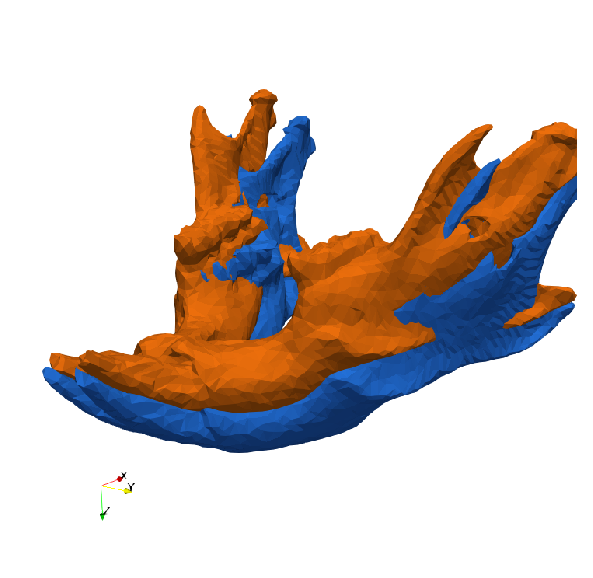

In [8]:
%matplotlib inline

### General Imports
from glob import glob
import os

working_directory = os.path.join(os.getcwd(), 'data', 'alignment')

### Find meshes and landmark files
meshfiles      = glob('{}{}*.vtk'.format(working_directory, os.sep))
landmarksfiles = glob('{}{}*.mps'.format(working_directory, os.sep))


meshfiles[:] = [el for el in meshfiles if not (('initial_template.vtk' in el) or ('_r.vtk' in el)) ]

### assert similar size and sort lists
assert(len(meshfiles) == len(landmarksfiles))
meshfiles.sort()
landmarksfiles.sort()

%matplotlib inline
import os
from matplotlib import pyplot as plt
pngfilename = os.path.join(os.getcwd(), 'Images', 'unaligned-meshes.png')
plt.figure(figsize=(10,10))
plt.imshow(plt.imread(pngfilename))
plt.axis('off')
plt.show()


## Mesh Alignment

Meshes and Landmarks lists of files are used to align all meshes into the 'mean' mesh.

The parameter **output_directory** allows to change where the output aligned meshes are saved. You can change the **suffix** of the aligned mesh files.

The meshes shapes do **not** change during this process.

It is recommended to use the **mode='similarity'**  for atlas construction in order to regress scaling from the variability.


In [9]:
output_meshes = align_meshes_to_center(meshfiles, landmarksfiles, mode='similarity', output_directory=working_directory, suffix='_r')

moving 1.vtk towards center with landmarks 1.mps -- determinant: 1.07
moving 2.vtk towards center with landmarks 2.mps -- determinant: 0.94


## Visualisation

You can visualise the resulting **aligned** meshes using [paraview](www.paraview.org).


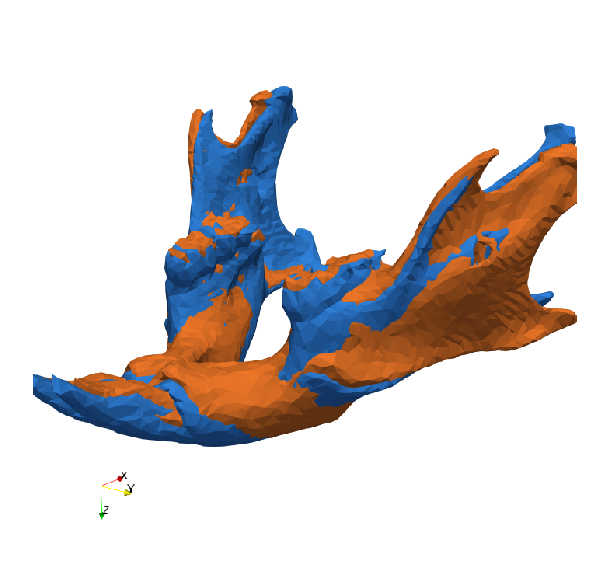

In [10]:
%matplotlib inline
import os
from matplotlib import pyplot as plt
pngfilename = os.path.join(os.getcwd(), 'Images', 'aligned-meshes.png')
plt.figure(figsize=(10,10))
plt.imshow(plt.imread(pngfilename))
plt.axis('off')
plt.show()

## Post-Processing information

The **aligned** meshes for **atlas construction**.

This alignment procedure can also output the centroid sizes. They can be calculated to verify that the resulting files have change volumes, and can be compared to the original meshes

Such centroid sizes can be visualised for comparison.


> Note that, in the case of **mode='similarity'**, after alignment, the centroid sizes narrow down towards the mean of the initial pre-aligned ones.

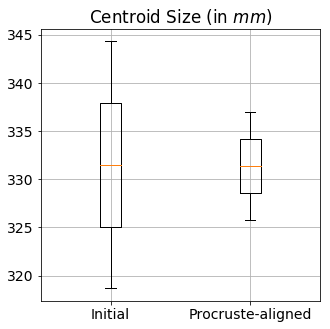

In [11]:
import numpy as np
cs1, cs2 = compare_centroid_sizes(meshfiles, output_meshes, label1='Initial', label2='Procruste-aligned')

> The centroid sizes can be saved on disk for future use, using **pandas** dataframe

In [12]:
import pandas as pd
imf = [os.path.basename(f) for f in meshfiles]
amf = [os.path.basename(f) for f in output_meshes]
lf = [os.path.basename(f) for f in landmarksfiles]
df = pd.DataFrame()
df['initial mesh file'] = imf
df['initial centroid size'] = cs1
df['landmark file'] = lf
df['aligned mesh file'] = amf
df['aligned centroid size'] = cs2
df.to_csv(os.path.join(working_directory, 'centroidsizes.csv'))


df


,initial mesh file,initial centroid size,landmark file,aligned mesh file,aligned centroid size
0,1.vtk,318.662474,1.mps,1_r.vtk,325.736104
1,2.vtk,344.307353,2.mps,2_r.vtk,336.989345


## About this notebook

written by Nicolas Toussaint

Contact: <nicolas.a.toussaint@kcl.ac.uk>